In [58]:
import mne
import numpy as np
import pandas as pd
from pathlib import Path
from mne.decoding import Vectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

### Read MEG data and metadata

In [131]:
ROOT = Path.cwd()                     # .../MEG/Data Analysis
MEG_ROOT = ROOT.parent                # .../MEG

LOCALIZER_EPO = (
    MEG_ROOT / "Data" / "Pilot" / "BIDS" / "derivatives" /
    "mne-bids-pipeline" / "sub-01" / "meg" / "sub-01_task-localizer_epo.fif"
)

epochs = mne.read_epochs(LOCALIZER_EPO)

# Read labels
df = pd.read_csv("metadata.csv")

print(df.head())

Reading /Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Data/Pilot/BIDS/derivatives/mne-bids-pipeline/sub-01/meg/sub-01_task-localizer_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Adding metadata with 3 columns
960 matching events found
No baseline correction applied
0 projection items activated
   subject_id       task  trial_block  trial_number stimulus_type meaning  \
0           1  localizer            1             1          word   carre   
1           1  localizer            1             2         image   croix   
2           1  localizer            1             3          word   dinde   
3           1  localizer            1             4         image   biche   
4           1  localizer            1             5          word  cercle   

  meaning_superordinate     stimulus participant_response  reaction_time  \
0                 shape   word_carre                  NaN            NaN

### Set X (data) and y (labels) for the model

In [172]:
X = epochs.pick_types(meg='mag').get_data()
n_trials, n_channels, n_times = X.shape

y = df["stimulus"].values

labels = ['image_carre', 'word_carre',
          'image_losange', 'word_losange',
          'image_croix', 'word_croix',
          'image_cercle', 'word_cercle',
          'image_biche', 'word_biche',
          'image_dinde', 'word_dinde',
          'image_lampe', 'word_lampe',
          'image_pince', 'word_pince']

labels = ['image_carre', 'image_losange', 'image_croix', 'image_cercle', 
          'image_biche', 'image_dinde', 
          'image_lampe','image_pince', 
          'word_carre', 'word_losange', 'word_croix', 'word_cercle',
          'word_biche', 'word_dinde',
          'word_lampe', 'word_pince'
          ]

d = {k:v for v, k in enumerate(labels)}

# Encode class labels to stable integer indices (ensures consistent column order across folds)
y_enc = np.array([d[s] for s in y])

NUM_CLASSES = df["stimulus"].nunique()

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


### Define classifiers

In [176]:
# Define pipeline: standardize features within folds, then linear classifier
clf = make_pipeline(
    StandardScaler(with_mean=True, with_std=True), 
    OneVsRestClassifier(LogisticRegression(C=1))
    )

# # One-vs-One wrapper around the whole pipeline
# ovo_clf = OneVsRestClassifier(LogisticRegression(C=1))

In [188]:
X = epochs.copy().crop(0.1, 0.5).get_data().mean(axis=2)

classes = set(y_enc)
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

y_pred = np.zeros((len(y_enc), len(classes)))
for train, test in cv.split(X, y_enc):
    # Fit
    clf.fit(X[train], y_enc[train])
    # Probabilistic prediction (necessary for ROC-AUC scoring metric)
    y_pred[test] = clf.predict_proba(X[test])

In [183]:
confusion = np.zeros((len(classes), len(classes)))
for ii, train_class in enumerate(classes):
    for jj in range(ii, len(classes)):
        confusion[ii, jj] = roc_auc_score(y_enc == train_class, y_pred[:, jj])
        confusion[jj, ii] = confusion[ii, jj]

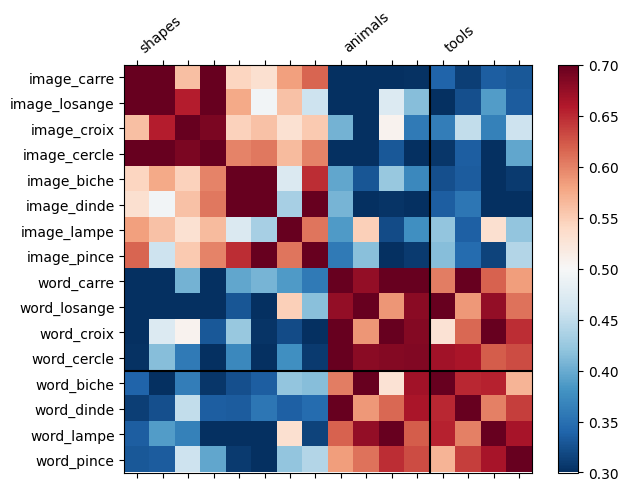

In [189]:
labels_plt = ["shapes"] + [""] * 7 + ["animals"] + [""] * 3 + ["tools"] + [""] * 3
#labels_plt = labels

fig, ax = plt.subplots(1, layout="constrained")
im = ax.matshow(confusion, cmap="RdBu_r", clim=[0.3, 0.7])
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(labels_plt, rotation=40, ha="left")
ax.axhline(11.5, color="k")
ax.axvline(11.5, color="k")
plt.colorbar(im)
plt.show()

In [190]:
rng = np.random.default_rng(0)

labels = np.array(labels)
is_img = np.array([lab.startswith("image") for lab in labels])
idx_img = np.where(is_img)[0]
idx_wrd = np.where(~is_img)[0]

im_im = confusion[np.ix_(idx_img, idx_img)]
wd_wd = confusion[np.ix_(idx_wrd, idx_wrd)]
im_wd = confusion[np.ix_(idx_img, idx_wrd)]

def upptri(m):  # upper triangle without diagonal
    return m[np.triu_indices_from(m, k=1)]

within = np.concatenate([upptri(im_im), upptri(wd_wd)])
between = im_wd.ravel()

delta_obs = within.mean() - between.mean()  # similarity case

# permutation null by shuffling image/word assignment
n_perm = 10000
n = len(labels); k = is_img.sum()
null = np.empty(n_perm)
all_idx = np.arange(n)
for p in range(n_perm):
    perm_img = rng.choice(all_idx, size=k, replace=False)
    perm_wrd = np.setdiff1d(all_idx, perm_img, assume_unique=False)
    im_im = confusion[np.ix_(perm_img, perm_img)]
    wd_wd = confusion[np.ix_(perm_wrd, perm_wrd)]
    im_wd = confusion[np.ix_(perm_img, perm_wrd)]
    null[p] = np.concatenate([upptri(im_im), upptri(wd_wd)]).mean() - im_wd.ravel().mean()

pval = (1 + (null >= delta_obs).sum()) / (1 + n_perm)  # one-sided: within > between
print(f"Δ = {delta_obs:.3f}, p = {pval:.4f}")

Δ = 0.278, p = 0.0001


8


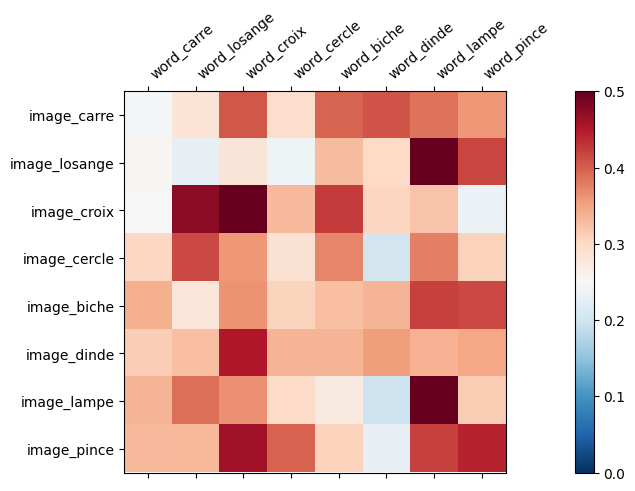

In [193]:
def generate_cross_modal_matrix(confusion, labels):
    image_idx = [i for i, name in enumerate(labels) if name.startswith("image")]
    word_idx  = [i for i, name in enumerate(labels) if name.startswith("word")]
    
    # Extract the image-word block
    im_wd = confusion[np.ix_(word_idx, image_idx)]
    n_items = im_wd.shape[0]  # should be 8

    print(len(labels[:max(image_idx) + 1]))

    _, ax = plt.subplots(1, layout="constrained")
    im = ax.matshow(im_wd, cmap="RdBu_r", clim=[0, 0.5])
    ax.set_yticks(range(n_items))
    ax.set_yticklabels(labels[:max(image_idx) + 1])
    ax.set_xticks(range(n_items))
    ax.set_xticklabels(labels[min(word_idx):max(word_idx) + 1], rotation=40, ha="left")
    plt.colorbar(im)
    plt.show()
    
generate_cross_modal_matrix(confusion, labels)

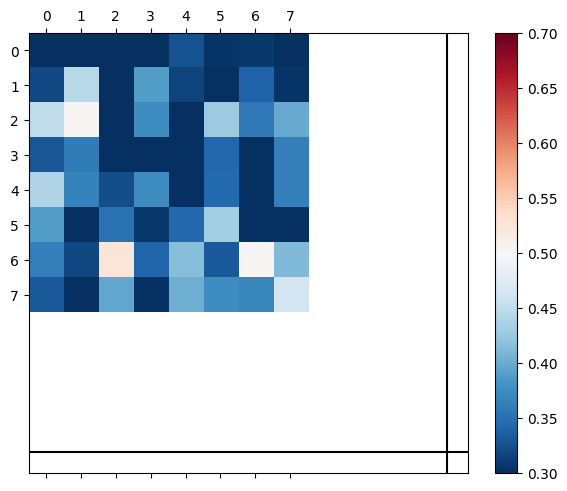

Δ(diag−offdiag) = 0.029, p = 0.1173


In [171]:
def test_cross_modal_generalization(confusion, labels, n_perm=10000, seed=0):
    rng = np.random.default_rng(seed)

    # Identify image vs word indices
    image_idx = [i for i, name in enumerate(labels) if name.startswith("image")]
    word_idx  = [i for i, name in enumerate(labels) if name.startswith("word")]

    # Extract the image-word block
    im_wd = confusion[np.ix_(image_idx, word_idx)]
    n_items = im_wd.shape[0]  # should be 8

    fig, ax = plt.subplots(1, layout="constrained")
    im = ax.matshow(im_wd, cmap="RdBu_r", clim=[0.3, 0.7])
    ax.set_yticks(range(n_items))
    # ax.set_yticklabels(labels)
    ax.set_xticks(range(n_items))
    # ax.set_xticklabels(labels_plt, rotation=40, ha="left")
    ax.axhline(11.5, color="k")
    ax.axvline(11.5, color="k")
    plt.colorbar(im)
    plt.show()

    # Observed: diagonal vs off-diagonal
    diag_vals = np.diag(im_wd)
    off_vals  = im_wd[~np.eye(n_items, dtype=bool)]
    delta_obs = diag_vals.mean() - off_vals.mean()

    # Permutation null: shuffle word labels
    null = np.empty(n_perm)
    for p in range(n_perm):
        perm = rng.permutation(n_items)
        permuted = im_wd[:, perm]
        diag = np.diag(permuted)
        off = permuted[~np.eye(n_items, dtype=bool)]
        null[p] = diag.mean() - off.mean()

    pval = (1 + (null >= delta_obs).sum()) / (1 + n_perm)  # one-sided
    return dict(delta=delta_obs, p=pval, null=null)

# Example
res = test_cross_modal_generalization(confusion, labels)
print(f"Δ(diag−offdiag) = {res['delta']:.3f}, p = {res['p']:.4f}")

In [149]:
def test_shapes_vs_nonshapes(confusion, labels, n_perm=10000, seed=0):
    rng = np.random.default_rng(seed)

    # Select only images
    image_idx = [i for i, name in enumerate(labels) if name.startswith("word")]
    image_labels = [labels[i] for i in image_idx]
    rdm_img = confusion[np.ix_(image_idx, image_idx)]


    # Define shapes vs nonshapes
    shape_idx = [i for i, name in enumerate(image_labels)
                 if any(x in name for x in ["carre", "losange", "croix", "cercle"])]
    nonshape_idx = [i for i in range(len(image_labels)) if i not in shape_idx]

    print(shape_idx)

    def upptri(x):
        return x[np.triu_indices_from(x, k=1)]

    # Observed
    sh_sh = rdm_img[np.ix_(shape_idx, shape_idx)]
    ns_ns = rdm_img[np.ix_(nonshape_idx, nonshape_idx)]
    sh_ns = rdm_img[np.ix_(shape_idx, nonshape_idx)]

    within = np.concatenate([upptri(sh_sh), upptri(ns_ns)])
    between = sh_ns.ravel()
    delta_obs = within.mean() - between.mean()

    # Permutation
    n = len(image_labels)
    k = len(shape_idx)
    null = np.empty(n_perm)
    all_idx = np.arange(n)
    for p in range(n_perm):
        perm_shape = rng.choice(all_idx, size=k, replace=False)
        perm_non = np.setdiff1d(all_idx, perm_shape)
        sh_sh = rdm_img[np.ix_(perm_shape, perm_shape)]
        ns_ns = rdm_img[np.ix_(perm_non, perm_non)]
        sh_ns = rdm_img[np.ix_(perm_shape, perm_non)]
        within = np.concatenate([upptri(sh_sh), upptri(ns_ns)])
        between = sh_ns.ravel()
        null[p] = within.mean() - between.mean()

    pval = (1 + (null >= delta_obs).sum()) / (1 + n_perm)
    return dict(delta=delta_obs, p=pval, null=null)

# Example usage:
res = test_shapes_vs_nonshapes(confusion, labels)
print(f"Δ(within−between) = {res['delta']:.3f}, p = {res['p']:.4f}")

[0, 1, 2, 3]
Δ(within−between) = 0.016, p = 0.2496
